# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
from skimage.transform import resize
from skimage.io import imread
import datetime
import os
import matplotlib.pyplot as plt

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
#tf.set_random_seed(30)
tf.random.set_seed(30)

In [3]:
# Importing libraries needed for Model building

from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Dropout, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

In [5]:
train_doc.size, val_doc.size

(663, 100)

In [6]:
train_doc[0]

'WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'

In [7]:
num_classes = 5

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def generator(source_path, folder_list, batch_size, height, width, img_idx=range(30)):
    # print( 'Source path = ', source_path, '; batch size =', batch_size)
    # print('height=',height,' width=',width,' img_idx=',img_idx)
    # img_idx = #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(height,width)).astype(np.float32)                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size != 0):
            batch_data = np.zeros((batch_size,len(img_idx),height,width,3))
            batch_labels = np.zeros((batch_size, num_classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    resized_image = resize(image,(height,width)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does 

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
print('Current Date Time: ', curr_dt_time)
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

Current Date Time:  2024-12-02 21:38:08.793631
# training sequences = 663
# validation sequences = 100
# epochs = 20


In [10]:
# Defining a helper function to plot the results of the model execution
def plot_results(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [11]:
def calculate_steps(batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    print(steps_per_epoch, validation_steps)
    return steps_per_epoch, validation_steps

In [12]:
def get_callbacks():
    model_dt_time = datetime.datetime.now()
    print('Current Model Date Time: ', model_dt_time)
    
    model_name = 'model_init' + '_' + str(model_dt_time).replace(' ','').replace(':','_') + '/'
    
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.001, cooldown=1, verbose=1) # write the REducelronplateau code here
    
    return [checkpoint, LR]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model1

##### CNN (Conv3D), 7 Images, Image Size=80x80

In [13]:
batch_size = 32
num_epochs = 30
image_index = [0,5,10,15,20,25,29] #create a list of image numbers
height = 80
width = 80

In [15]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 7, 80, 80, 32)       │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 3, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 3, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 1, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,696,773 (6.47 MB)

 Trainable params: 1,696,773 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [19]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print(steps_per_epoch, validation_steps)

21 4
21 4


In [21]:
callbacks_list = get_callbacks()

Current Model Date Time:  2024-11-30 19:23:56.914193


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [22]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-11-3019_23_56.914193/model-00001-1.81344-0.21875-1.57898-0.21094.keras
21/21 - 59s - 3s/step - categorical_accuracy: 0.2188 - loss: 1.8134 - val_categorical_accuracy: 0.2109 - val_loss: 1.5790 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-11-3019_23_56.914193/model-00002-1.56159-0.27232-1.49072-0.25781.keras
21/21 - 43s - 2s/step - categorical_accuracy: 0.2723 - loss: 1.5616 - val_categorical_accuracy: 0.2578 - val_loss: 1.4907 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-11-3019_23_56.914193/model-00003-1.35051-0.43899-1.11736-0.50781.keras
21/21 - 45s - 2s/step - categorical_accuracy: 0.4390 - loss: 1.3505 - val_categorical_accuracy: 0.5078 - val_loss: 1.1174 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-11-3019_23_56.914193/model-00004-1.05893-0.59077-1.05832-0.60156.keras
21/21 - 48s - 2s/step - categorical_accuracy: 0.5908 - loss: 1.058

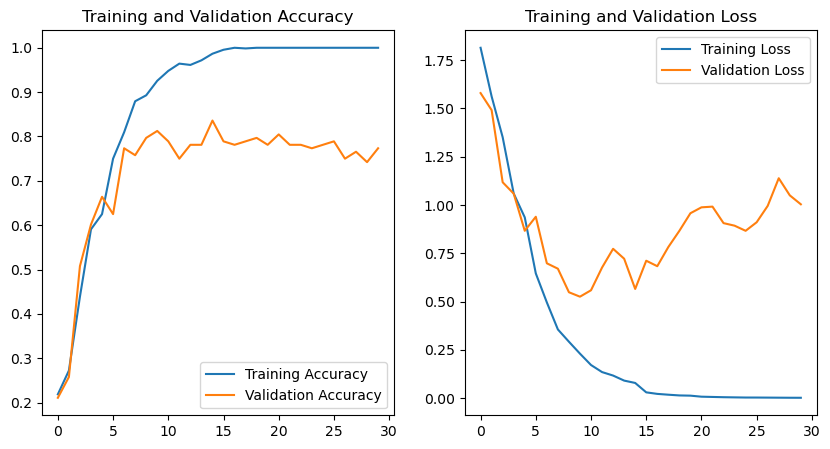

In [23]:
plot_results(history)

#### Observations - Model is significantly overfitting. Will add normalization and drop out layers.

### Model2

##### CNN (Conv3D, BN, Dropout), 7 Images, Image Size=80x80

In [25]:
batch_size = 32
num_epochs = 30
image_index = [0,5,10,15,20,25,29] #create a list of image numbers
height = 80
width = 80

In [38]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_7 (Conv3D)                    │ (None, 7, 80, 80, 32)       │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 80, 80, 32)       │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 3, 40, 40, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_8 (Conv3D)                    │ (None, 3, 40, 40, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 40, 40, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 1, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,697,157 (6.47 MB)

 Trainable params: 1,696,965 (6.47 MB)

 Non-trainable params: 192 (768.00 B)

None


In [39]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-11-30 20:11:41.727621


In [40]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-11-3020_11_41.727621/model-00001-5.02458-0.26488-2.38045-0.17188.keras
21/21 - 66s - 3s/step - categorical_accuracy: 0.2649 - loss: 5.0246 - val_categorical_accuracy: 0.1719 - val_loss: 2.3804 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-11-3020_11_41.727621/model-00002-1.48656-0.36905-2.28408-0.21875.keras
21/21 - 54s - 3s/step - categorical_accuracy: 0.3690 - loss: 1.4866 - val_categorical_accuracy: 0.2188 - val_loss: 2.2841 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-11-3020_11_41.727621/model-00003-1.36834-0.41369-2.17827-0.22656.keras
21/21 - 60s - 3s/step - categorical_accuracy: 0.4137 - loss: 1.3683 - val_categorical_accuracy: 0.2266 - val_loss: 2.1783 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-11-3020_11_41.727621/model-00004-1.15290-0.50149-2.62125-0.28906.keras
21/21 - 51s - 2s/step - categorical_accuracy: 0.5015 - loss: 1.152

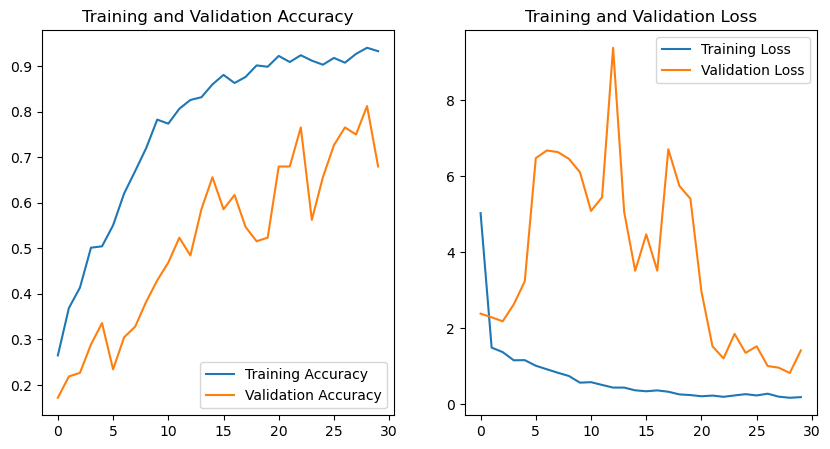

In [41]:
plot_results(history)

#### Observations - The overfitting is controlled. But the validation accuracy is not good. Include more images in the training and verify the results.

### Model3

##### CNN (Conv3D, BN, Dropout), 20 Images, Image Size=80x80

In [ ]:
batch_size = 32
num_epochs = 30
image_index = [0, 2, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 29] #create a list of 20 images
# print(len(image_index))
height = 80
width = 80

In [63]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_24 (Conv3D)                   │ (None, 20, 80, 80, 32)      │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 20, 80, 80, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_24 (MaxPooling3D)      │ (None, 10, 40, 40, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_25 (Conv3D)                   │ (None, 10, 40, 40, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 10, 40, 40, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_25 (MaxPooling3D)      │ (None, 5, 20, 20, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 128000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │       8,192,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,250,757 (31.47 MB)

 Trainable params: 8,250,565 (31.47 MB)

 Non-trainable params: 192 (768.00 B)

None


In [64]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-11-30 22:00:22.945222


In [65]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-11-3022_00_22.945222/model-00001-22.79204-0.32440-16.63858-0.22656.keras
21/21 - 234s - 11s/step - categorical_accuracy: 0.3244 - loss: 22.7920 - val_categorical_accuracy: 0.2266 - val_loss: 16.6386 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-11-3022_00_22.945222/model-00002-2.88734-0.33333-4.78432-0.21875.keras
21/21 - 176s - 8s/step - categorical_accuracy: 0.3333 - loss: 2.8873 - val_categorical_accuracy: 0.2188 - val_loss: 4.7843 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-11-3022_00_22.945222/model-00003-1.88816-0.30952-3.72988-0.31250.keras
21/21 - 152s - 7s/step - categorical_accuracy: 0.3095 - loss: 1.8882 - val_categorical_accuracy: 0.3125 - val_loss: 3.7299 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-11-3022_00_22.945222/model-00004-1.75241-0.29464-5.33830-0.32812.keras
21/21 - 181s - 9s/step - categorical_accuracy: 0.2946 - lo

CPU times: total: 1h 55min 53s
Wall time: 1h 33min 6s


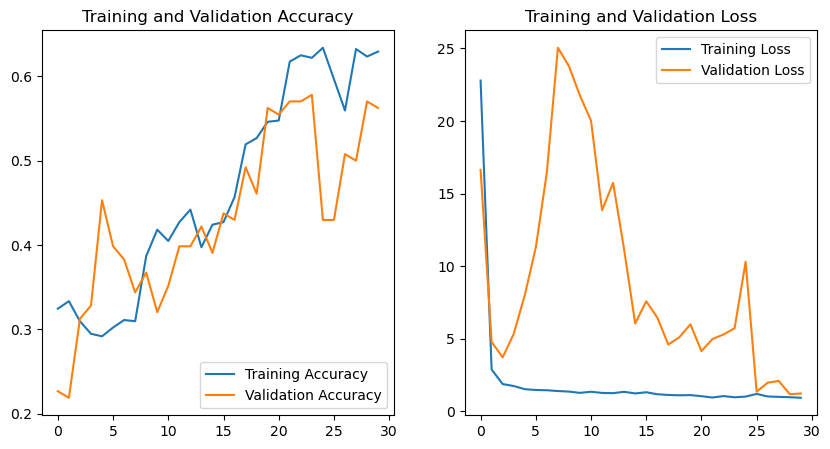

In [66]:
plot_results(history)

#### Observations - The training accuracy has fell significantly. Meaning model is underfitting and hasn't learnt. Adding additional convolution layers to improve learning.

### Model4

##### CNN (3 Conv3D Layers, BN, Dropout), 20 Images, Image Size=80x80

In [86]:
batch_size = 32
num_epochs = 30
image_index = [0, 2, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 29] #create a list of 20 images
# print(len(image_index))
height = 80
width = 80

In [87]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(Conv3D(16, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_52 (Conv3D)                   │ (None, 20, 80, 80, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 20, 80, 80, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_50 (MaxPooling3D)      │ (None, 10, 40, 40, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_53 (Conv3D)                   │ (None, 10, 40, 40, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 10, 40, 40, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_51 (MaxPooling3D)      │ (None, 5, 20, 20, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_54 (Conv3D)                   │ (None, 5, 20, 20, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 5, 20, 20, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_52 (MaxPooling3D)      │ (None, 2, 10, 10, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │         819,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,565 (3.40 MB)

 Trainable params: 890,341 (3.40 MB)

 Non-trainable params: 224 (896.00 B)

None


In [88]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-11-30 23:50:32.303859


In [89]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-11-3023_50_32.303859/model-00001-2.64244-0.35119-2.87634-0.19531.keras
21/21 - 133s - 6s/step - categorical_accuracy: 0.3512 - loss: 2.6424 - val_categorical_accuracy: 0.1953 - val_loss: 2.8763 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-11-3023_50_32.303859/model-00002-1.28056-0.47917-2.48802-0.29688.keras
21/21 - 111s - 5s/step - categorical_accuracy: 0.4792 - loss: 1.2806 - val_categorical_accuracy: 0.2969 - val_loss: 2.4880 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-11-3023_50_32.303859/model-00003-0.96863-0.59226-5.08442-0.32812.keras
21/21 - 107s - 5s/step - categorical_accuracy: 0.5923 - loss: 0.9686 - val_categorical_accuracy: 0.3281 - val_loss: 5.0844 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-11-3023_50_32.303859/model-00004-0.80634-0.67262-15.09090-0.14844.keras
21/21 - 116s - 6s/step - categorical_accuracy: 0.6726 - loss: 

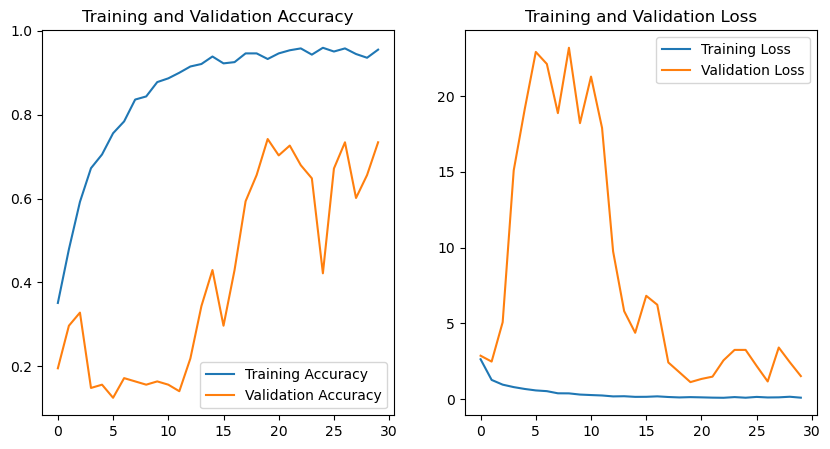

In [90]:
plot_results(history)

#### Observations - The results are better with both training and validation accuracy improving. Lets use larger image sizes and see if the results improve.

### Model5

##### CNN (3 Conv3D Layers, BN, Dropout), 20 Images, Image Size=120x120

In [91]:
batch_size = 32
num_epochs = 30
image_index = [0, 2, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 29] #create a list of 20 images
# print(len(image_index))
height = 120
width = 120

In [92]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(Conv3D(16, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d_55 (Conv3D)                   │ (None, 20, 120, 120, 16)    │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 20, 120, 120, 16)    │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_53 (MaxPooling3D)      │ (None, 10, 60, 60, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_56 (Conv3D)                   │ (None, 10, 60, 60, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 10, 60, 60, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_54 (MaxPooling3D)      │ (None, 5, 30, 30, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_57 (Conv3D)                   │ (None, 5, 30, 30, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 5, 30, 30, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_55 (MaxPooling3D)      │ (None, 2, 15, 15, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 64)                  │       1,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,914,565 (7.30 MB)

 Trainable params: 1,914,341 (7.30 MB)

 Non-trainable params: 224 (896.00 B)

None


In [93]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-12-01 09:17:38.604092


In [94]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-12-0109_17_38.604092/model-00001-6.49589-0.35417-14.28814-0.22656.keras
21/21 - 347s - 17s/step - categorical_accuracy: 0.3542 - loss: 6.4959 - val_categorical_accuracy: 0.2266 - val_loss: 14.2881 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-12-0109_17_38.604092/model-00002-1.54583-0.36012-4.39161-0.28125.keras
21/21 - 201s - 10s/step - categorical_accuracy: 0.3601 - loss: 1.5458 - val_categorical_accuracy: 0.2812 - val_loss: 4.3916 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-12-0109_17_38.604092/model-00003-1.21721-0.50149-2.37829-0.30469.keras
21/21 - 175s - 8s/step - categorical_accuracy: 0.5015 - loss: 1.2172 - val_categorical_accuracy: 0.3047 - val_loss: 2.3783 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-12-0109_17_38.604092/model-00004-1.00761-0.60119-3.98838-0.35938.keras
21/21 - 198s - 9s/step - categorical_accuracy: 0.6012 - los

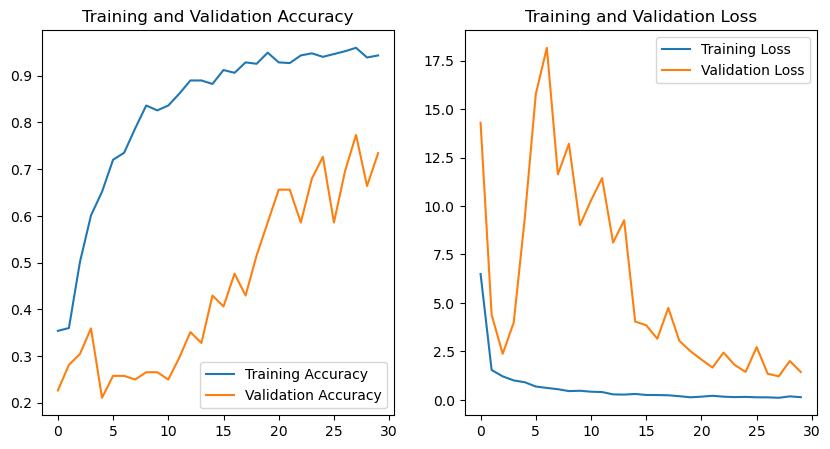

In [95]:
plot_results(history)

#### Observations - Having larger sizes images of 120x120 instead of 80x80 has not resulted in much increase in accuracy. No improvement seen.

### Model6

##### CNN (3 Conv3D Layers, BN, Dropout) + LSTM , 20 Images, Image Size=80x80

In [120]:
batch_size = 32
num_epochs = 30
image_index = [0, 2, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 29] #create a list of 20 images
# print(len(image_index))
height = 80
width = 80

In [121]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_7 (TimeDistributed) │ (None, 20, 80, 80, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 80, 80, 16)      │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 40, 40, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 40, 40, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 40, 40, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 20, 20, 20, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 20, 20, 20, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 20, 20, 20, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 20, 10, 10, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 20, 6400)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │       1,655,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,683,557 (6.42 MB)

 Trainable params: 1,683,333 (6.42 MB)

 Non-trainable params: 224 (896.00 B)

None


In [122]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-12-01 12:11:03.500506


In [123]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-12-0112_11_03.500506/model-00001-1.56567-0.29762-1.59198-0.24219.keras
21/21 - 225s - 11s/step - categorical_accuracy: 0.2976 - loss: 1.5657 - val_categorical_accuracy: 0.2422 - val_loss: 1.5920 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-12-0112_11_03.500506/model-00002-1.33754-0.47024-1.21449-0.51562.keras
21/21 - 218s - 10s/step - categorical_accuracy: 0.4702 - loss: 1.3375 - val_categorical_accuracy: 0.5156 - val_loss: 1.2145 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-12-0112_11_03.500506/model-00003-1.15388-0.58780-1.04038-0.60938.keras
21/21 - 212s - 10s/step - categorical_accuracy: 0.5878 - loss: 1.1539 - val_categorical_accuracy: 0.6094 - val_loss: 1.0404 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-12-0112_11_03.500506/model-00004-0.98489-0.65179-0.91433-0.72656.keras
21/21 - 354s - 17s/step - categorical_accuracy: 0.6518 - los

CPU times: total: 2h 29min 29s
Wall time: 2h 26min 8s


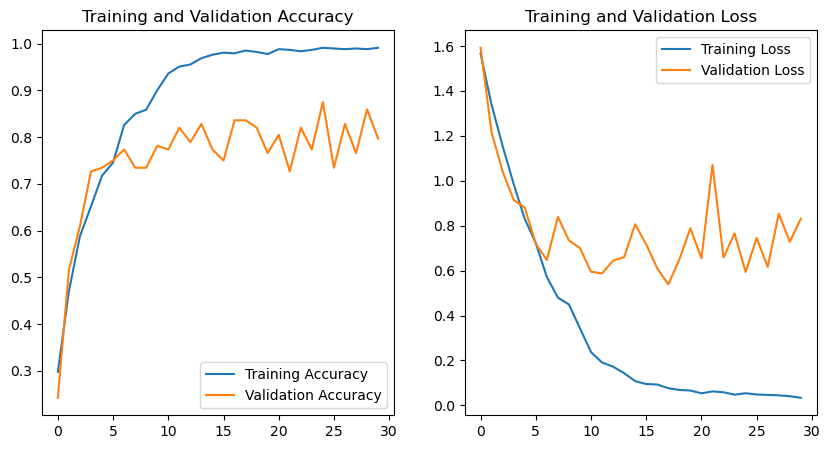

In [124]:
plot_results(history)

#### Observations - With CNN+LSTM, the parameter count is high, the time taken has increased significantly. But both the training and validation accuracy are looking good. 

### Model7

##### CNN (3 Conv3D Layers, BN, Dropout) + GRU , 20 Images, Image Size=80x80

In [129]:
batch_size = 32
num_epochs = 30
image_index = [0, 2, 4, 5, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20, 22, 24, 25, 26, 28, 29] #create a list of 20 images
# print(len(image_index))
height = 80
width = 80

In [130]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(64))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_27                  │ (None, 20, 80, 80, 16)      │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 20, 80, 80, 16)      │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 20, 40, 40, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, 20, 40, 40, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, 20, 40, 40, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, 20, 20, 20, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 20, 20, 20, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 20, 20, 20, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 20, 10, 10, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_36                  │ (None, 20, 6400)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │       1,241,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,269,989 (4.84 MB)

 Trainable params: 1,269,765 (4.84 MB)

 Non-trainable params: 224 (896.00 B)

None


In [131]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-12-01 14:40:59.989714


In [132]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-12-0114_40_59.989714/model-00001-1.56201-0.34375-1.56762-0.30469.keras
21/21 - 241s - 11s/step - categorical_accuracy: 0.3438 - loss: 1.5620 - val_categorical_accuracy: 0.3047 - val_loss: 1.5676 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-12-0114_40_59.989714/model-00002-1.30057-0.45685-1.14599-0.57812.keras
21/21 - 199s - 9s/step - categorical_accuracy: 0.4568 - loss: 1.3006 - val_categorical_accuracy: 0.5781 - val_loss: 1.1460 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-12-0114_40_59.989714/model-00003-1.08978-0.57292-1.04037-0.58594.keras
21/21 - 203s - 10s/step - categorical_accuracy: 0.5729 - loss: 1.0898 - val_categorical_accuracy: 0.5859 - val_loss: 1.0404 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-12-0114_40_59.989714/model-00004-0.92149-0.66815-0.88010-0.67188.keras
21/21 - 237s - 11s/step - categorical_accuracy: 0.6682 - loss

CPU times: total: 2h 31min 7s
Wall time: 1h 48min 51s


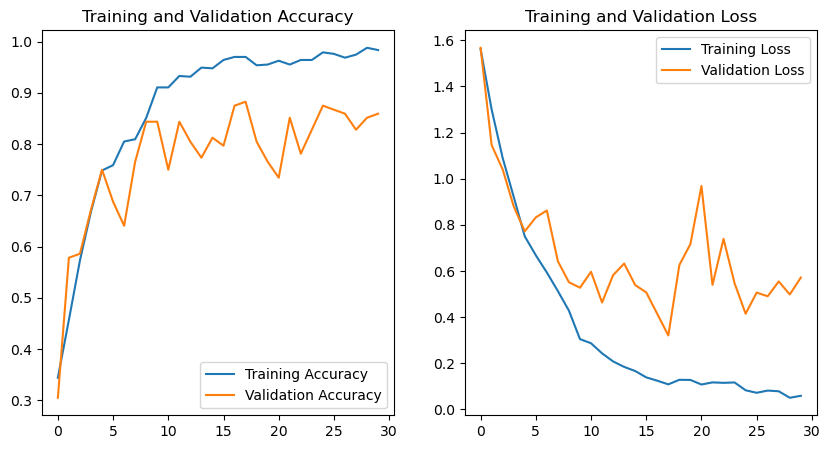

In [133]:
plot_results(history)

#### Observations - With CNN+GRU, the training and validation accuracy are looking good.

### Model8

##### CNN (3 Conv3D Layers, BN, Dropout), All 30 Images, Image Size=80x80

In [ ]:
batch_size = 32
num_epochs = 30
image_index = range(30)
print(len(image_index))
height = 80
width = 80

In [15]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(Conv3D(16, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 30, 80, 80, 16)      │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 80, 80, 16)      │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 15, 40, 40, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 15, 40, 40, 32)      │          13,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 15, 40, 40, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 7, 20, 20, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 7, 20, 20, 64)       │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 20, 20, 64)       │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 3, 10, 10, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 19200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,165 (4.96 MB)

 Trainable params: 1,299,941 (4.96 MB)

 Non-trainable params: 224 (896.00 B)

None


In [16]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-12-01 16:44:02.086803


In [17]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-12-0116_44_02.086803/model-00001-3.10535-0.32440-3.32057-0.24219.keras
21/21 - 303s - 14s/step - categorical_accuracy: 0.3244 - loss: 3.1054 - val_categorical_accuracy: 0.2422 - val_loss: 3.3206 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-12-0116_44_02.086803/model-00002-1.41367-0.37351-6.11380-0.17188.keras
21/21 - 196s - 9s/step - categorical_accuracy: 0.3735 - loss: 1.4137 - val_categorical_accuracy: 0.1719 - val_loss: 6.1138 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-12-0116_44_02.086803/model-00003-1.25011-0.42560-2.59317-0.17969.keras
21/21 - 161s - 8s/step - categorical_accuracy: 0.4256 - loss: 1.2501 - val_categorical_accuracy: 0.1797 - val_loss: 2.5932 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-12-0116_44_02.086803/model-00004-1.06879-0.53274-3.84640-0.31250.keras
21/21 - 171s - 8s/step - categorical_accuracy: 0.5327 - loss: 

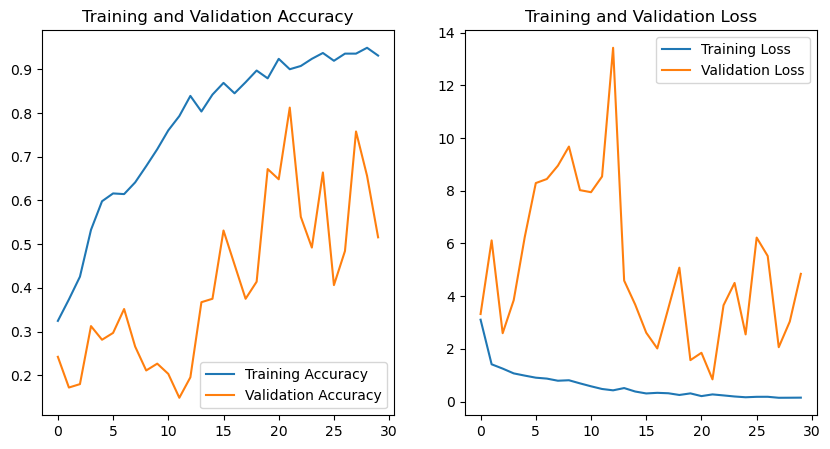

In [18]:
plot_results(history)

#### Observations - With all 30 images used, there is a significant variation in the validation accuracy. The model is not stable.

### Model9

##### CNN (3 Conv3D Layers, BN, Dropout) + LSTM, All 30 Images, Image Size=80x80

In [20]:
batch_size = 32
num_epochs = 30
image_index = range(30)
print(len(image_index))
height = 80
width = 80

30


In [21]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(64))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 30, 80, 80, 16)      │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 30, 80, 80, 16)      │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 40, 40, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 30, 40, 40, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 30, 40, 40, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 30, 20, 20, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 30, 20, 20, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 30, 20, 20, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 30, 10, 10, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 30, 6400)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │       1,655,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,683,557 (6.42 MB)

 Trainable params: 1,683,333 (6.42 MB)

 Non-trainable params: 224 (896.00 B)

None


In [22]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-12-01 18:39:51.674273


In [23]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-12-0118_39_51.674273/model-00001-1.56987-0.29018-1.37294-0.57031.keras
21/21 - 526s - 25s/step - categorical_accuracy: 0.2902 - loss: 1.5699 - val_categorical_accuracy: 0.5703 - val_loss: 1.3729 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-12-0118_39_51.674273/model-00002-1.29829-0.53423-1.16541-0.64844.keras
21/21 - 363s - 17s/step - categorical_accuracy: 0.5342 - loss: 1.2983 - val_categorical_accuracy: 0.6484 - val_loss: 1.1654 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-12-0118_39_51.674273/model-00003-1.02600-0.65923-0.95978-0.67188.keras
21/21 - 351s - 17s/step - categorical_accuracy: 0.6592 - loss: 1.0260 - val_categorical_accuracy: 0.6719 - val_loss: 0.9598 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-12-0118_39_51.674273/model-00004-0.86436-0.70982-0.91438-0.64844.keras
21/21 - 311s - 15s/step - categorical_accuracy: 0.7098 - los

CPU times: total: 4h 15min 30s
Wall time: 3h 6min 5s


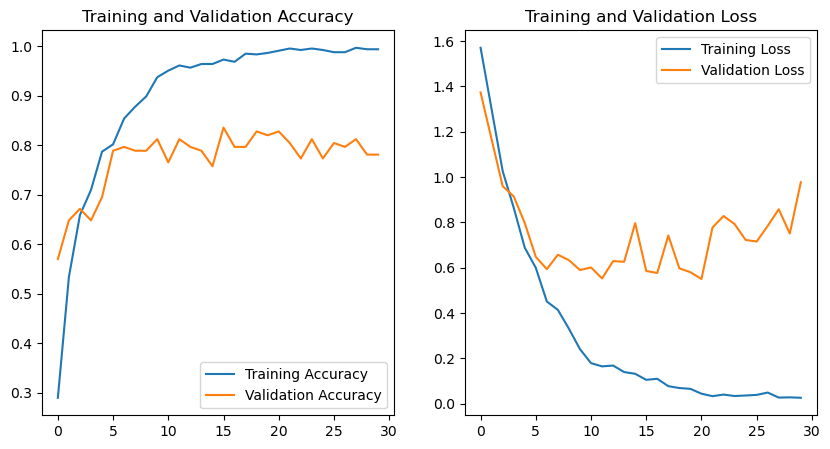

In [24]:
plot_results(history)

#### Observations - The results are good. But the validation accuracy is not significantly improved in this case with 30 images compared to the results with only subset of 20 images.

### Model10

##### CNN (3 Conv3D Layers, BN, Dropout) + GRU , All 30 Images, Image Size=80x80

In [26]:
batch_size = 32
num_epochs = 30
image_index = range(30)
print(len(image_index))
height = 80
width = 80

30


In [27]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(64))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_10                  │ (None, 30, 80, 80, 16)      │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 30, 80, 80, 16)      │              64 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 30, 40, 40, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 30, 40, 40, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 30, 40, 40, 32)      │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 30, 20, 20, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_16                  │ (None, 30, 20, 20, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_17                  │ (None, 30, 20, 20, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_18                  │ (None, 30, 10, 10, 64)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 30, 6400)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │       1,241,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,269,989 (4.84 MB)

 Trainable params: 1,269,765 (4.84 MB)

 Non-trainable params: 224 (896.00 B)

None


In [28]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-12-01 22:03:11.531981


In [29]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-12-0122_03_11.531981/model-00001-1.56293-0.33631-1.30377-0.53906.keras
21/21 - 386s - 18s/step - categorical_accuracy: 0.3363 - loss: 1.5629 - val_categorical_accuracy: 0.5391 - val_loss: 1.3038 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-12-0122_03_11.531981/model-00002-1.30726-0.48363-1.11777-0.64844.keras
21/21 - 507s - 24s/step - categorical_accuracy: 0.4836 - loss: 1.3073 - val_categorical_accuracy: 0.6484 - val_loss: 1.1178 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-12-0122_03_11.531981/model-00003-0.99138-0.63988-0.92221-0.69531.keras
21/21 - 314s - 15s/step - categorical_accuracy: 0.6399 - loss: 0.9914 - val_categorical_accuracy: 0.6953 - val_loss: 0.9222 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-12-0122_03_11.531981/model-00004-0.86336-0.67113-0.81170-0.74219.keras
21/21 - 338s - 16s/step - categorical_accuracy: 0.6711 - los

CPU times: total: 4h 12min 49s
Wall time: 2h 52min 41s


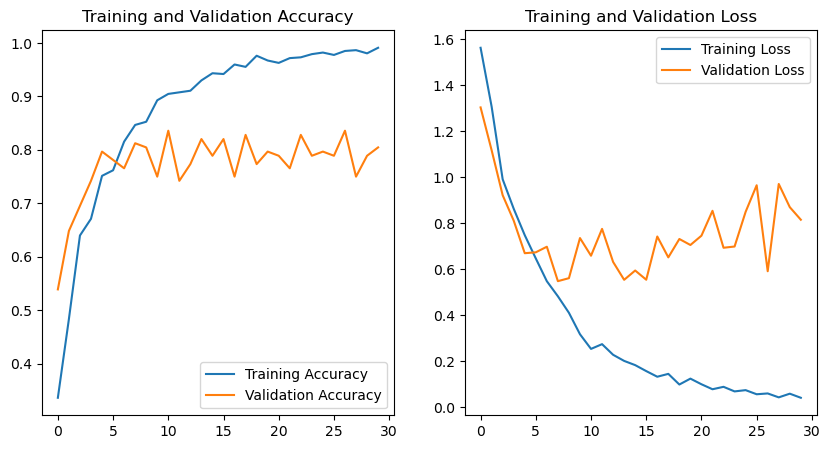

In [30]:
plot_results(history)

#### Observations - The results are good. But the validation accuracy is not significantly improved in this case with 30 images compared to the results with only subset of 20 images.

### Model11

##### Transfer Learning using MobileNetv2 + GRU , All 30 Images, Image Size=80x80

In [31]:
batch_size = 32
num_epochs = 30
image_index = range(30)
print(len(image_index))
height = 80
width = 80

30


In [32]:
# Importing the mobilenet transfer learning model 
from keras.applications import MobileNetV2

mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='max')

C:\Users\SG0303523\AppData\Local\Temp\ipykernel_28236\362444487.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights='imagenet', include_top=False, pooling='max')


In [33]:
model = Sequential()
model.add(Input(shape=(len(image_index), height, width, 3)))
model.add(TimeDistributed(mobilenet))
for layer in model.layers:
          layer.trainable = False          

model.add(TimeDistributed(Flatten()))
model.add(GRU(64))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_10                  │ (None, 30, 1280)            │       2,257,984 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 30, 1280)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │         258,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,520,901 (9.62 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [34]:
train_generator = generator(train_path, train_doc, batch_size, height, width, image_index)
val_generator = generator(val_path, val_doc, batch_size, height, width, image_index)
steps_per_epoch, validation_steps = calculate_steps(batch_size)
print('steps_per_epoch =',steps_per_epoch, ' validation_steps =',validation_steps)
callbacks_list = get_callbacks()

21 4
steps_per_epoch = 21  validation_steps = 4
Current Model Date Time:  2024-12-02 22:21:02.642689


In [35]:
%%time
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=2, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps)

Epoch 1/30

Epoch 1: saving model to model_init_2024-12-0222_21_02.642689/model-00001-1.61766-0.28274-1.31396-0.50781.keras
21/21 - 388s - 18s/step - categorical_accuracy: 0.2827 - loss: 1.6177 - val_categorical_accuracy: 0.5078 - val_loss: 1.3140 - learning_rate: 0.0010
Epoch 2/30

Epoch 2: saving model to model_init_2024-12-0222_21_02.642689/model-00002-1.22535-0.53571-1.11406-0.58594.keras
21/21 - 234s - 11s/step - categorical_accuracy: 0.5357 - loss: 1.2254 - val_categorical_accuracy: 0.5859 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 3/30

Epoch 3: saving model to model_init_2024-12-0222_21_02.642689/model-00003-0.93587-0.66667-0.99453-0.62500.keras
21/21 - 212s - 10s/step - categorical_accuracy: 0.6667 - loss: 0.9359 - val_categorical_accuracy: 0.6250 - val_loss: 0.9945 - learning_rate: 0.0010
Epoch 4/30

Epoch 4: saving model to model_init_2024-12-0222_21_02.642689/model-00004-0.75205-0.73214-0.85929-0.70312.keras
21/21 - 248s - 12s/step - categorical_accuracy: 0.7321 - los

CPU times: total: 2h 6min 59s
Wall time: 1h 54min 11s


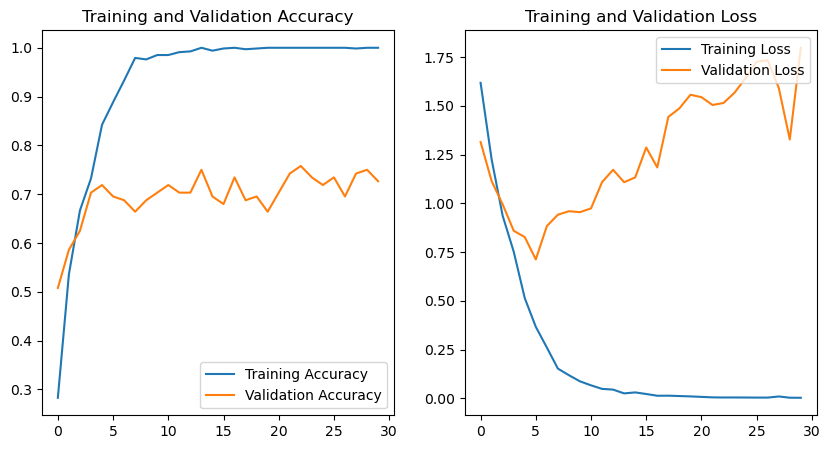

In [36]:
plot_results(history)

#### Observations - The results show overfitting. Also the validation loss is increasing with more epochs.

#### Final Conclusion/Model Selection 
#### Based on the results observed, we will select Model 7 from above list for the final model. 
#### GRU+CNN (3 Conv2D layers, BN, Dropout)
#### This has good accuracy. Train Accuracy - 0.9836, Validation Accuracy - 0.8594. 
#### The number of parameters(12,69,989) are also lower compared to other models.
#### The saved model fill will be model-00030-0.05919-0.98363-0.57175-0.85938.keras